In [1]:
import pandas as pd
import matplotlib 
from utils import *
from training import *

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat_peak > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat_peak > -100')

data = pd.concat([bgu, bdu]).sort_values('reportts').drop(columns=['file_path', 'dep', 'arr'])


In [2]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202403260034.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).drop(columns=['processedts']).sort_values('reportts', ignore_index=True)

acms_full.shape

(138812, 207)

### Visualize updated theta-correction procedure

In [3]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  alpha_2 = 0.869

  theta = (data['t2'] + 273.16) / (288.16)
  theta_peak = (data['t2_peak'] + 273.16) / (288.16)
  delta = data['p2e'] / 29.92

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.16) / (theta ** alpha_2)
  datak['egtk_2'] = (data['egt'] + 273.16) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** 0.59))

  datak['egt_peak_k'] = (data['egt_peak'] + 273.16) / (theta_peak ** alpha_2)
  datak['n1a_peak_k'] = data['n1a_peak'] / (theta_peak ** alpha)
  datak['n1_peak_k'] = data['n1_peak'] / (theta_peak ** alpha)
  datak['n2a_peak_k'] = data['n2a_peak'] / (theta_peak ** alpha)

  return datak

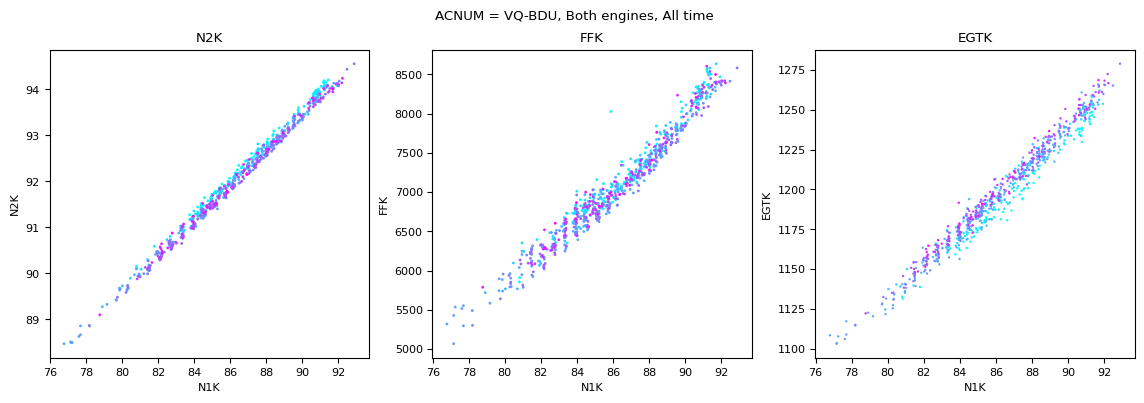

In [4]:
data = correct(bdu)

def plot_baselines(data, title):
  plt.rcParams.update({'font.size': 8})
  fig, axs = plt.subplots(1, 3)
  fig.set_size_inches(14, 4)
  fig.suptitle(title)
  
  cm = matplotlib.colormaps['cool']

  axs[0].scatter(data['n1ak'], data['n2ak'], s=1, c=data['reportts'], cmap=cm)
  axs[0].set(xlabel='N1K', ylabel='N2K', title="N2K")

  axs[1].scatter(data['n1ak'], data['ffk'], s=1, c=data['reportts'], cmap=cm)
  axs[1].set(xlabel='N1K', ylabel='FFK', title="FFK")

  axs[2].scatter(data['n1ak'], data['egtk'], s=0.5, c=data['reportts'], cmap=cm)
  axs[2].set(xlabel='N1K', ylabel='EGTK', title="EGTK")

  plt.show()

plot_baselines(data.query('pos == 1'), title='ACNUM = VQ-BDU, Both engines, All time')

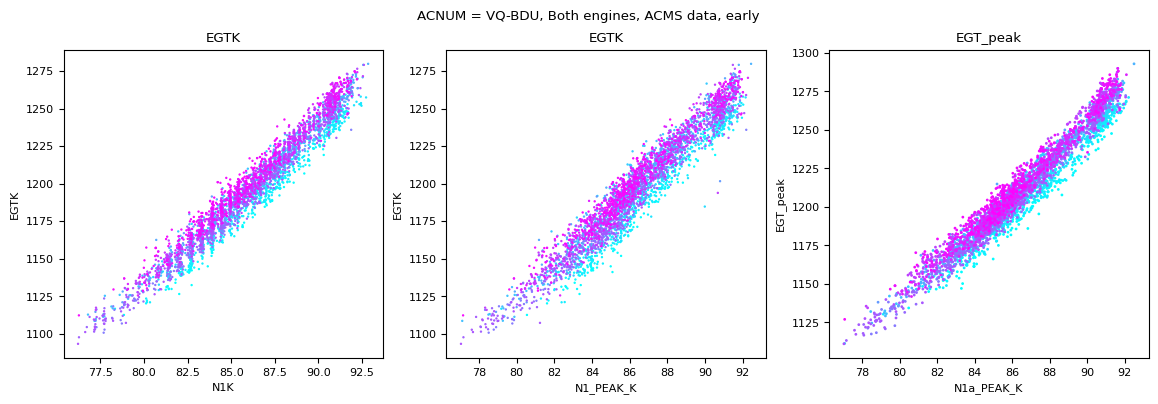

In [5]:
acms_data = correct(acms_full.query(f"acnum=='VQ-BDU' and pos==2 and n1a_peak < 100"))

plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
fig.suptitle('ACNUM = VQ-BDU, Both engines, ACMS data, early')

axs[0].scatter(acms_data['n1ak'], acms_data['egtk'], s=0.5, c=acms_data['reportts'], cmap='cool')
axs[0].set(xlabel='N1K', ylabel='EGTK', title="EGTK")

axs[1].scatter(acms_data['n1_peak_k'], acms_data['egtk'], s=0.5, c=acms_data['reportts'], cmap='cool')
axs[1].set(xlabel='N1_PEAK_K', ylabel='EGTK', title="EGTK")

axs[2].scatter(acms_data['n1a_peak_k'], acms_data['egt_peak_k'], s=1, c=acms_data['reportts'], cmap='cool')
axs[2].set(xlabel='N1a_PEAK_K', ylabel='EGT_peak', title="EGT_peak")

plt.show()

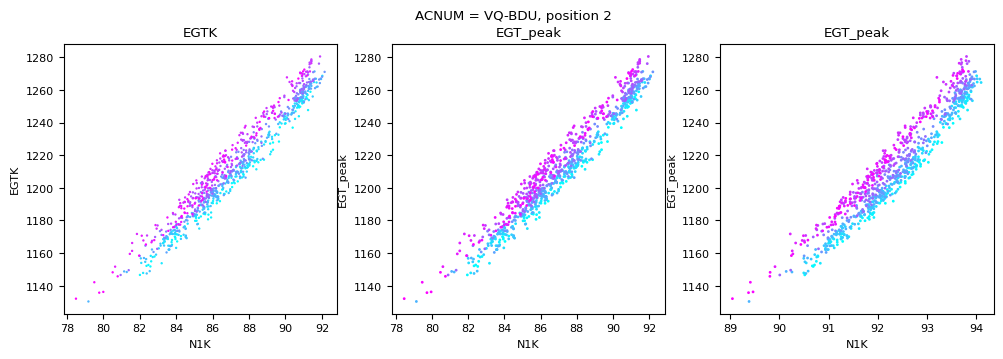

In [6]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 3.5)
fig.suptitle('ACNUM = VQ-BDU, position 2')

data_bdu = correct(bdu).query('pos == 2 and reportts < "2019-06-01"')

axs[0].scatter(data_bdu['n1_peak_k'], data_bdu['egt_peak_k'], s=0.5, c=data_bdu['reportts'], cmap='cool')
axs[0].set(xlabel='N1K', ylabel='EGTK', title="EGTK")

axs[1].scatter(data_bdu['n1a_peak_k'], data_bdu['egt_peak_k'], s=1, c=data_bdu['reportts'], cmap='cool')
axs[1].set(xlabel='N1K', ylabel='EGT_peak', title="EGT_peak")

axs[2].scatter(data_bdu['n2a_peak_k'], data_bdu['egt_peak_k'], s=1, c=data_bdu['reportts'], cmap='cool')
axs[2].set(xlabel='N1K', ylabel='EGT_peak', title="EGT_peak")

plt.show()

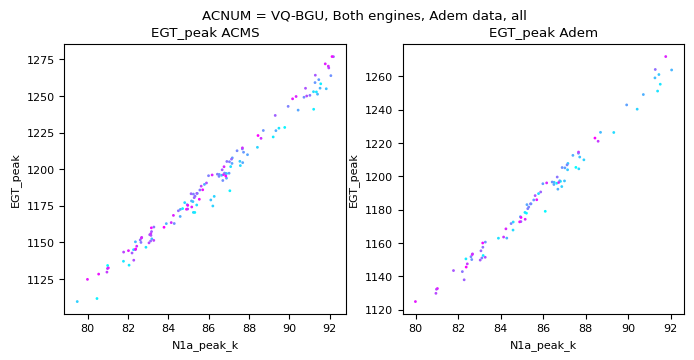

In [7]:
date_to = "2019-02-01"
data_bgu = correct(bgu).query("pos == 2 and reportts > '2019-01-01' and reportts < @date_to")
acms_bgu = correct(acms_full.query(f"acnum == 'VQ-BGU' and pos == 2 and t2_peak >= -100 and reportts < @date_to"))

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3.5)
fig.suptitle('ACNUM = VQ-BGU, Both engines, Adem data, all')

axs[0].scatter(acms_bgu['n1a_peak_k'], acms_bgu['egt_peak_k'], s=1, c=acms_bgu['reportts'], cmap='cool')
axs[0].set(xlabel='N1a_peak_k', ylabel='EGT_peak', title="EGT_peak ACMS")

axs[1].scatter(data_bgu['n1a_peak_k'], data_bgu['egt_peak_k'], s=1, c=data_bgu['reportts'], cmap='cool')
axs[1].set(xlabel='N1a_peak_k', ylabel='EGT_peak', title="EGT_peak Adem")

plt.show()

Train an engine baseline:

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')][:30]

model = LinearRegression()
model.fit(sub[['n1ak']], sub['egtk'])

pred = model.predict(sub[['n1ak']])

r2 = r2_score(sub['egtk'],  pred)

f"R2 = {r2}"

'R2 = 0.9881923572757363'

In [9]:
sub[['n1ak', 'oat_peak']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 781 to 810
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   n1ak      30 non-null     float64
 1   oat_peak  30 non-null     float64
dtypes: float64(2)
memory usage: 720.0 bytes


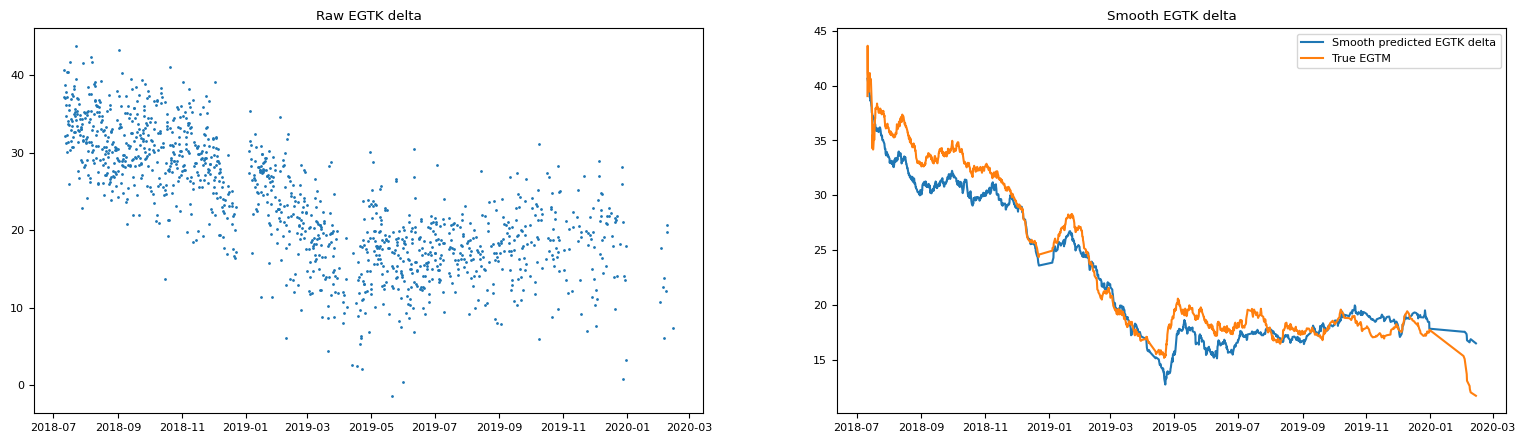

In [10]:
sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')]

baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk'] + 35

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.04))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')][:20]

model = LinearRegression()
model.fit(sub[['n1a_peak_k']], sub['egt_peak_k'])

pred = model.predict(sub[['n1a_peak_k']])

r2 = r2_score(sub['egt_peak_k'],  pred)

print(f"Linear model R2 = {r2}")

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(sub[['n1a_peak_k']], sub['egt_peak_k'])

pred = model.predict(sub[['n1a_peak_k']])

r2 = r2_score(sub['egt_peak_k'],  pred)

print(f"Quadratic model R2 = {r2}")

model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(sub[['n1a_peak_k']], sub['egt_peak_k'])

pred = model.predict(sub[['n1a_peak_k']])

r2 = r2_score(sub['egt_peak_k'],  pred)

print(f"Cubic model R2 = {r2}")



Linear model R2 = 0.9907155074618174
Quadratic model R2 = 0.9948139125863821
Cubic model R2 = 0.9948380438600095


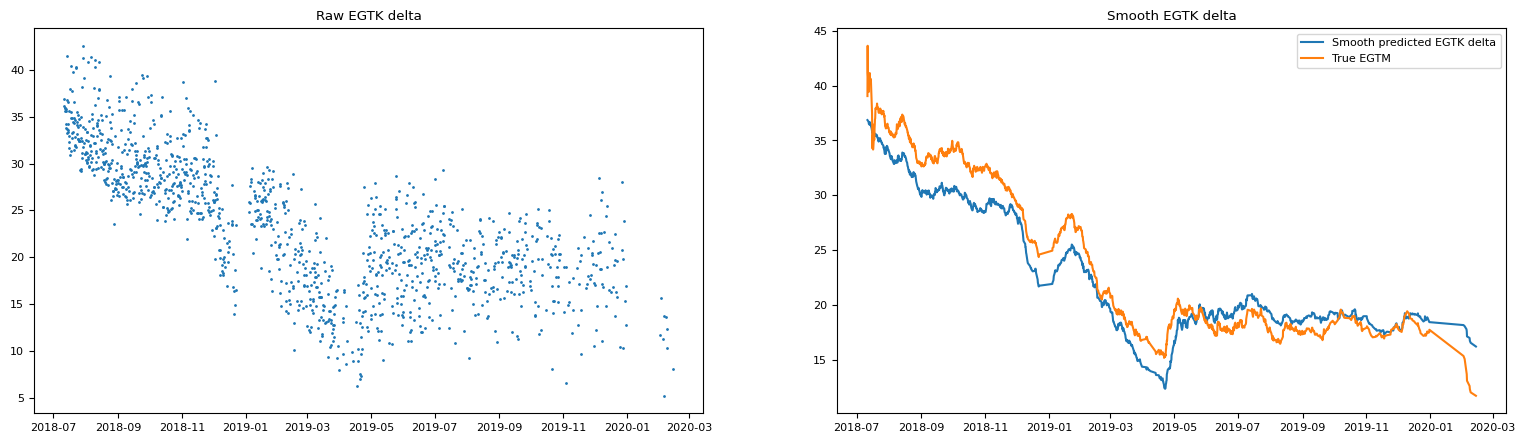

In [12]:
sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')]

baseline = model.predict(sub[['n1a_peak_k']])
delta = baseline - sub['egt_peak_k'] + 35

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.04))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

Experiment with N2A: 

R2 = 0.9932484434026208


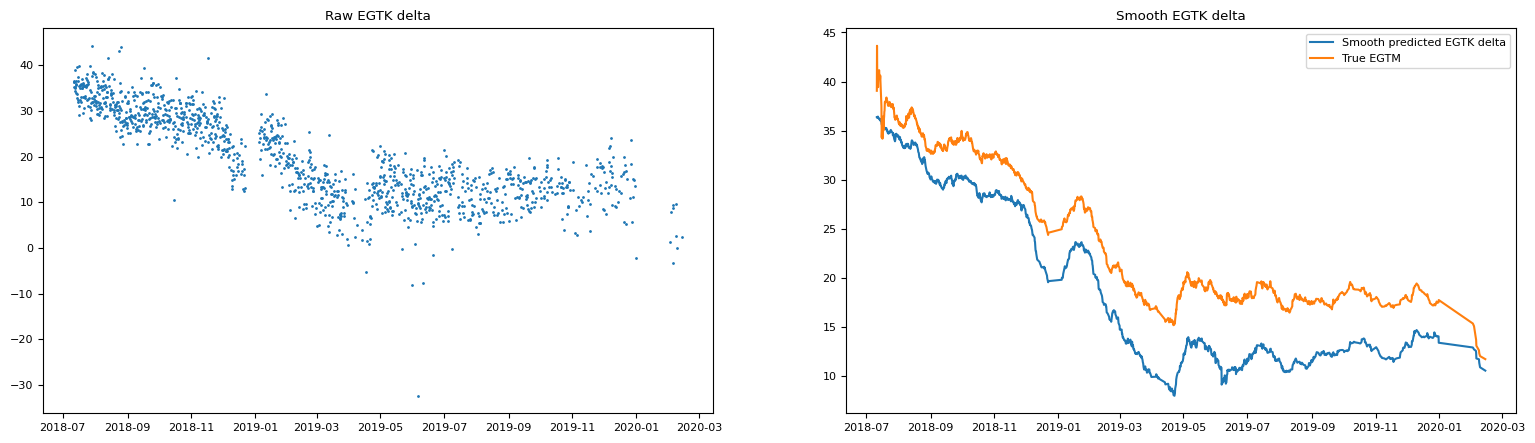

In [13]:
sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')][:30]

model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(sub[['n2a_peak_k']], sub['egt_peak_k'])

pred = model.predict(sub[['n2a_peak_k']])

r2 = r2_score(sub['egt_peak_k'],  pred)

print(f"R2 = {r2}")

sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')]

baseline = model.predict(sub[['n2a_peak_k']])
delta = baseline - sub['egt_peak_k'] + 35

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.04))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

R2 = 0.976385364326422


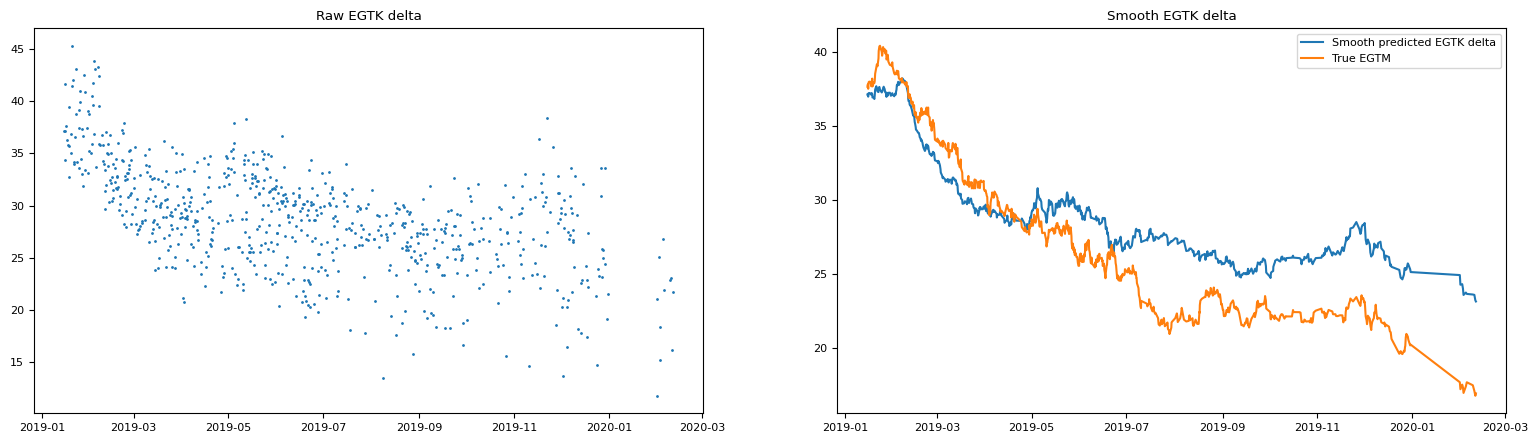

In [14]:
acms_data = correct(acms_full.query(f"acnum == 'VQ-BGU' and pos == 2 and t2_peak >= -100"))[:340]

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(acms_data[['n1a_peak_k']], acms_data['egt_peak_k'])

pred = model.predict(acms_data[['n1a_peak_k']])

r2 = r2_score(acms_data['egt_peak_k'],  pred)

print(f"R2 = {r2}")

data_bgu = correct(bgu).query("pos == 2 and reportts > '2019-01-15'")

sub = data_bgu[(data_bgu['pos'] == 2)]

baseline = model.predict(sub[['n1a_peak_k']])
delta = baseline - sub['egt_peak_k'] + 35

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.05))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

idea: merge VQ-BGU again

### Next steps:

0. Попробовать использовать EGT_peak вместо EGT [done]

1. Вывести Delta EGTK из train выборки (75%) [done]
2. Предсказать Delta EGTK для всего датасета и добавить как признак [done]
3. Сравнить качество с Экспериментом 5  [done]
4. Разделить на неск. baseline по altitude (=3000)  [done]
5. Рекурсия  [done]
6. Bleed учесть (bool params)  [done]

### Try to replace EGT with EGT_peak

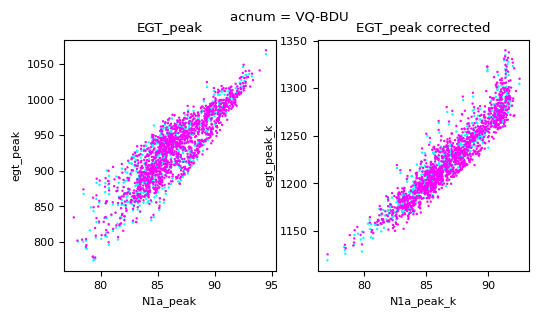

In [15]:
data = correct(bdu.query('egt_peak > 0').copy())

theta = (data['oat'] + 273.15) / 288.15
egt_peak = data['egt_peak']
egt_peak_k = (egt_peak + 273.15) / (theta ** 0.84)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(6, 3)
fig.suptitle('acnum = VQ-BDU')

axs[0].scatter(data['n1a_peak'], egt_peak, s=0.5, c=data['pos'], cmap='cool')
axs[0].set(xlabel='N1a_peak', ylabel='egt_peak')
axs[0].set_title('EGT_peak')

axs[1].scatter(data['n1a_peak_k'], egt_peak_k, s=0.5, c=data['pos'], cmap='cool')
axs[1].set(xlabel='N1a_peak_k', ylabel='egt_peak_k')
axs[1].set_title('EGT_peak corrected')
plt.show()

### Baselines for each engine

In [16]:
def train_engine_baseline(points: pd.DataFrame, x_param='n1a_peak_k', y_param='egt_peak_k'):
  model = make_pipeline(PolynomialFeatures(2), LinearRegression())
  model.fit(points[[x_param]], points[y_param])
  return model

def compute_egtm(points: pd.DataFrame, model: LinearRegression, x_param='n1a_peak_k'):
  offset = 30
  delta = model.predict(points[[x_param]]) - points['egt_peak_k']
  return delta + offset

def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])
  predicted_test_smooth = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum)
      test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum)

      model = train_engine_baseline(X_train[train_index])
      
      models[f'{acnum}_{pos}'] = model
      
      predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
      predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)
      predicted_test_smooth.loc[test_index, 'pred'] = smooth(compute_egtm(X_test[test_index], model), 0.05)
  
  print("Smooth metrics: ", get_metrics(y_test, predicted_test_smooth))

  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [17]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

Smooth metrics:  {'rmse': 5.02531, 'mae': 3.88962, 'r2': -1.45238, 'mape': 0.18863}


{'rmse': 6.08647, 'mae': 4.92813, 'r2': -2.59743, 'mape': 0.23242}

In [18]:
bgu[['prv', 'hpv', 'wai', 'nai']].describe(percentiles=[])

,prv,hpv,wai,nai
count,1656.000000,1656.0,1656.0,1656.000000
mean,0.523551,0.0,0.0,0.098430
std,0.499596,0.0,0.0,0.297985
min,0.000000,0.0,0.0,0.000000
50%,1.000000,0.0,0.0,0.000000
max,1.000000,0.0,0.0,1.000000


Only prv and nai are present, try to filter them out and plot whats left

In [19]:
def train_model_bleed(X, y, bleed_param='prv'):
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])
  predicted_test_smooth = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      for bleed in [0, 1]:
        train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum) & (X_train[bleed_param] == bleed)
        test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum) & (X_test[bleed_param] == bleed)

        model = train_engine_baseline(X_train[train_index])
        
        models[f'{acnum}_{pos}_{bleed}'] = model
        
        predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
        predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)

        predicted_test_smooth.loc[test_index, 'pred'] = smooth(compute_egtm(X_test[test_index], model), 0.05)

  print("Smooth metrics: ", get_metrics(y_test, predicted_test_smooth))
  
  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [20]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model_bleed(X, y)

metrics

Smooth metrics:  {'rmse': 3.79727, 'mae': 2.97416, 'r2': -0.40024, 'mape': 0.13925}


{'rmse': 4.56243, 'mae': 3.69413, 'r2': -1.0214, 'mape': 0.17049}

In [21]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model_bleed(X, y, bleed_param='nai')

metrics

Smooth metrics:  {'rmse': 5.14103, 'mae': 4.01913, 'r2': -1.56662, 'mape': 0.19468}


{'rmse': 6.10738, 'mae': 4.99818, 'r2': -2.62219, 'mape': 0.23526}

In [22]:
def train_model_bleed_alt(X, y, bleed_param='prv'):
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])
  predicted_test_smooth = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      for bleed in [0, 1]:
        for (alt_lo, alt_hi) in [[0, 3000], [3000, 10_000]]:
          train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum) \
              & (X_train[bleed_param] == bleed) & (alt_lo <= X_train['alt']) & (X_train['alt'] < alt_hi)
          test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum) \
              & (X_test[bleed_param] == bleed) & (alt_lo <= X_test['alt']) & (X_test['alt'] < alt_hi)

          model = train_engine_baseline(X_train[train_index])
          
          models[f'{acnum}_{pos}_{bleed}'] = model
          
          predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
          predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)

          predicted_test_smooth.loc[test_index, 'pred'] = smooth(compute_egtm(X_test[test_index], model), 0.05)

  print("Smooth metrics: ", get_metrics(y_test, predicted_test_smooth))
  
  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [23]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model_bleed_alt(X, y, bleed_param='prv')

metrics

Smooth metrics:  {'rmse': 4.06225, 'mae': 3.18029, 'r2': -0.60249, 'mape': 0.14886}


{'rmse': 4.65371, 'mae': 3.71105, 'r2': -1.1031, 'mape': 0.17121}

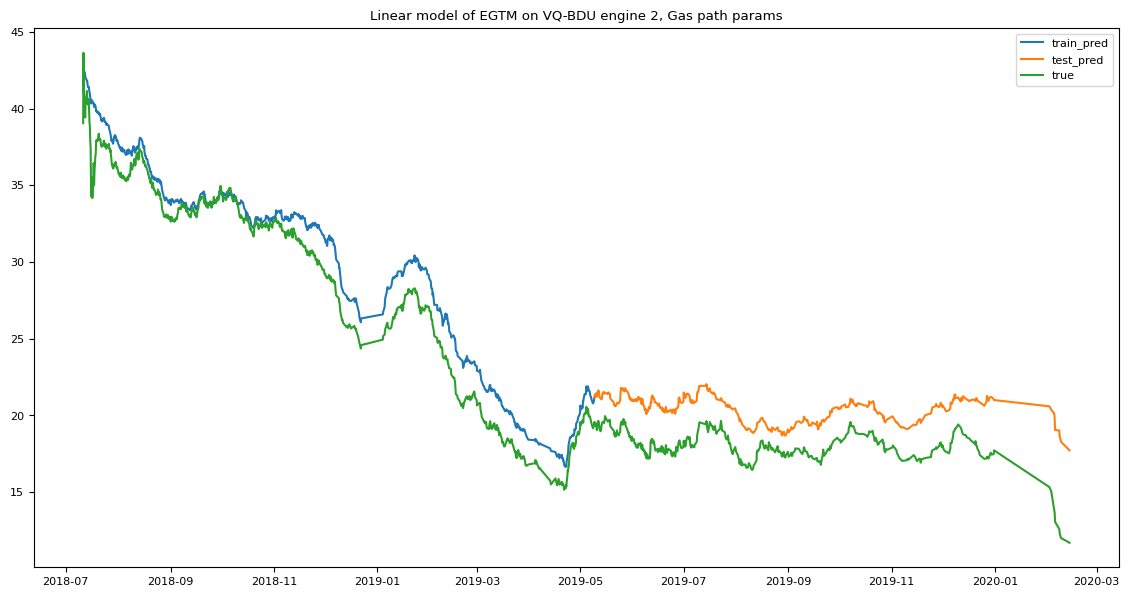

In [24]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.05)

### Add calculated EGT delta as additional property to dataset to use in recursive model later

In [25]:
def add_egt_delta_to_dataset(dataset: pd.DataFrame, bleed_param='prv', fleet=[]):
  for acnum in fleet: 
    for pos in [1, 2]:
      for bleed in [0, 1]:
        subset_index = (dataset['pos'] == pos) & (dataset['acnum'] == acnum) & (dataset[bleed_param] == bleed)
        baseline = train_engine_baseline(dataset[subset_index])
        egt_delta = compute_egtm(dataset[subset_index], baseline)
        dataset.loc[subset_index, 'egt_delta'] = egt_delta

      subset_index = (dataset['pos'] == pos) & (dataset['acnum'] == acnum) 
      egt_delta = dataset.loc[subset_index, 'egt_delta']
      egt_delta_smooth = smooth(egt_delta, 0.05)
      dataset.loc[subset_index, 'egt_delta_smooth'] = egt_delta_smooth

  return dataset

In [26]:
dataset_with_delta = add_egt_delta_to_dataset(data, fleet=fleet)

In [27]:
# dataset_with_delta.to_csv("VQ-BDU_VQ-BGU_with_delta.csv", index=False)

In [28]:
dataset_with_delta.columns[dataset_with_delta.columns.str.endswith("peak")]

Index(['alt_peak', 'cas_peak', 'dflm_peak', 'dfsm_peak', 'dnflm_peak',
       'dnfsm_peak', 'egt_peak', 'mn_peak', 'mne_peak', 'n1_peak', 'n1a_peak',
       'n1c2_peak', 'n1com_peak', 'n1max_peak', 'n2a_peak', 'nf_peak',
       'oat_peak', 't2_peak', 'tat_peak'],
      dtype='object')

In [29]:
dataset_with_delta.columns[dataset_with_delta.columns.str.startswith("egt")]

Index(['egtm', 'egt', 'egt_peak', 'egtb', 'egtk', 'egtk_2', 'egt_peak_k',
       'egt_delta', 'egt_delta_smooth'],
      dtype='object')